# Projet Python pour la data science 

Auteurs : NGUEMOGNE Sandra, Rougier Antoine

L'objectif de ce notebook est de présenter le projet que nous avons effectué dans le cadre de l'unité d'enseignement Python pour la data science dispensée à l'ENSAE. Ce projet a été élaboré de manière libre et comporte, comme attendu, un jeu de données récupéré et traité, une partie visualisation et une partie modélisation.

# Problématique 

Ce projet s'articule autour de la problématique suivante : Comment peut-on créer une modélisation pertinente des prix que nous cherchons, et comment peut-on comparer cela avec une véritable stratégie financière ? (le modèle Black-Sholes)

La structure est divisée en deux parties distinctes :
- dans un premier temps, nous allons récupérer le jeu de donnée, et basé notre modèle dessus 
- puis nous utiliserons la méthode Black-Sholes pour comparer les deux méthodes 

# Installations préalables 

Avant d'exécuter veuillez procéder aux installations de modules nécessaires au bon fonctionnement du code en exécutant la cellule ci-dessous.

In [1]:
!pip install yfinance
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 18.9 MB/s eta 0:00:0000:0100:01


# Importation des modules 

In [24]:
import yfinance as yahooFinance
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_X_y
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Récupération et traitement des données 

La première étape de notre projet a été la récupération et le traitement des données. Dans notre cas, nous avons fait le choix de récupérer des données fournis directement sur le site Yahoo Finance.

In [37]:
start_Date = datetime.datetime(2019, 1, 1)
end_Date = datetime.datetime(2019, 12, 31)

GetAXAInfo = yahooFinance.Ticker("CS.PA")
df_init=GetAXAInfo.history(start=start_Date,end=end_Date)

# Visualisation des données 

Nous voulons d'abord savoir le nombre de ligne que comporte ce tableau, puis nous voulons connaître les informations qui se trouvent dans chaque colonnes. 

In [12]:
print(len(df_init))
print(df_init.columns)

255
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [33]:
print(df_init)

                                Open       High        Low      Close  \
Date                                                                    
2019-01-02 00:00:00+01:00  13.595195  13.738302  13.455007  13.731000   
2019-01-03 00:00:00+01:00  13.599576  13.836142  13.589354  13.617100   
2019-01-04 00:00:00+01:00  13.720778  14.087309  13.666748  14.044960   
2019-01-07 00:00:00+01:00  14.078547  14.150100  13.900393  13.982168   
2019-01-08 00:00:00+01:00  14.027438  14.218735  13.988011  14.034739   
...                              ...        ...        ...        ...   
2019-12-23 00:00:00+01:00  19.585070  19.666321  19.507689  19.646975   
2019-12-24 00:00:00+01:00  19.546381  19.623762  19.492215  19.546381   
2019-12-25 00:00:00+01:00  19.546381  19.546381  19.546381  19.546381   
2019-12-27 00:00:00+01:00  19.646974  19.685665  19.503820  19.507689   
2019-12-30 00:00:00+01:00  19.507689  19.592808  19.418701  19.418701   

                             Volume  Dividends  St

On remarque à ce moment-là que certaines colonnes semblent vides, comme celle de dividends ou de stock splits.
De plus, les dates peuvent poser un problème dans notre modélisation, car elles sont converties sous le format Unix, et que les heures ne nous intérèssent pas particulière dans notre projet.
Nous allons d'abord convertir ces dates dans un format qui ne nous posera pas de problème, puis vérifier la pertinence de ces deux autres colonnes. 

In [38]:
df_init = df_init.reset_index()
df_init["Date"] = df_init["Date"].dt.strftime('%Y-%m-%d')
df_init = df_init.set_index('Date')
df_init


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,13.595196,13.738302,13.455008,13.731001,8028529,0.0,0
2019-01-03,13.599574,13.836140,13.589352,13.617098,6583413,0.0,0
2019-01-04,13.720779,14.087309,13.666749,14.044961,11675578,0.0,0
2019-01-07,14.078547,14.150100,13.900393,13.982168,7530045,0.0,0
2019-01-08,14.027438,14.218735,13.988011,14.034739,7314687,0.0,0
...,...,...,...,...,...,...,...
2019-12-23,19.585070,19.666321,19.507689,19.646975,3952999,0.0,0
2019-12-24,19.546381,19.623762,19.492215,19.546381,1072973,0.0,0
2019-12-25,19.546381,19.546381,19.546381,19.546381,0,0.0,0


In [40]:
print(max(df_init['Stock Splits']))
print(max(df_init['Dividends']))

#On peut donc supprimer la colonne Stock Splits 
df_init = df_init.drop(columns =  ["Low", "High", "Dividends","Stock Splits"])
df_init

0
1.34


,Open,Close,Volume
Date,,,
2019-01-02,13.595196,13.731001,8028529
2019-01-03,13.599574,13.617098,6583413
2019-01-04,13.720779,14.044961,11675578
2019-01-07,14.078547,13.982168,7530045
2019-01-08,14.027438,14.034739,7314687
...,...,...,...
2019-12-23,19.585070,19.646975,3952999
2019-12-24,19.546381,19.546381,1072973
2019-12-25,19.546381,19.546381,0


Nous avons remarqué que finalement, la colonne dividends n'est pas toujours nulle. Tandis que celle de stock splits l'était. Dans la suite de notre projet, nous n'utiliserons plus les colonnes Dividends, High et Low, nous décidons donc de les supprimer aussi. 

# Visualisation des données 

Nous voulons d'abord regarder le graphique des prix de l'action Axa sur l'année 2019. Puis nous aimerions aussi voir le volume échanger sur chaque mois, pour voir s'il n'existarait pas une corrélation entre le volume échanger et les prix de l'action 

Text(0.5, 0, 'Temps')

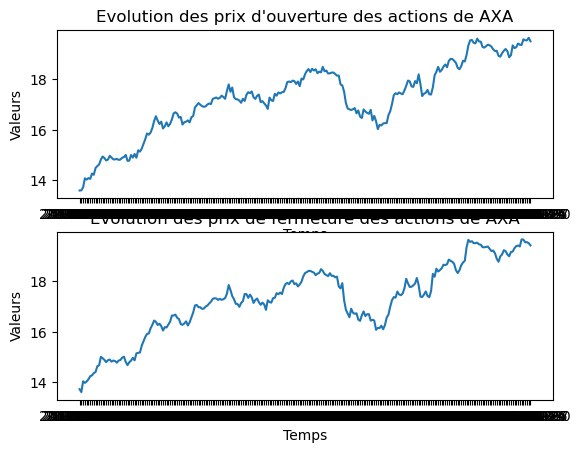

In [56]:
df2 = df_init.copy()
new_df = df2[['Open']]
new_df2 = df2[['Close']]
plt.subplot(211)
plt.plot(new_df)
plt.title("Evolution des prix d'ouverture des actions de AXA")
plt.ylabel("Valeurs")
plt.xlabel("Temps")

plt.subplot(212)
plt.plot(new_df2)
plt.title("Evolution des prix de fermeture des actions de AXA")
plt.ylabel("Valeurs")
plt.xlabel("Temps")

Nous voyons ici que les prix croissent à un certains rythme et que qu'il n'y a pas d'erreur dans nos données pour les prix d'ouverture. Nous n'avons pas de valeur abérante qui fausserait le graphique. Nous en concluons alors que nous pouvons utiliser cette base de donnée pour faire notre modèle.

On veut aussi avoir un histogramme qui nous montre le nombre de transaction par mois de l'action AXA pour voir si il y a une évolution 

/tmp/ipykernel_128/912966316.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = df_grouped.sum()


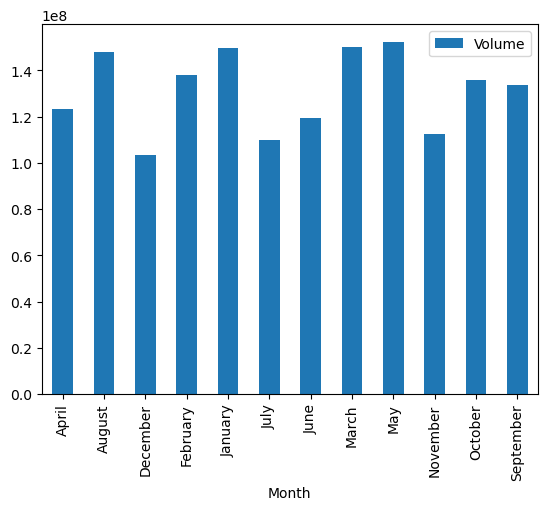

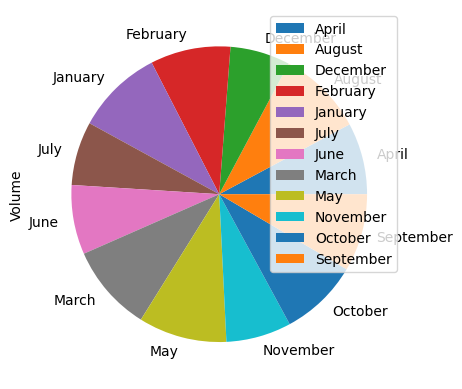

,Open,Volume
Open,1.00000,-0.24745
Volume,-0.24745,1.00000


In [43]:
new_df = df2[['Volume']]
new_df
new_df = new_df.reset_index()
new_df['Month'] = pd.to_datetime(new_df['Date']).dt.strftime('%B')
df_grouped = new_df.groupby(new_df['Month'])


#for key, item in df_grouped:
#    print(key)
#    print(df_grouped.get_group(key))

sums = df_grouped.sum()
sums
sums.plot.bar()
plt.show()

sums.plot.pie(subplots=True)
plt.show()

df2 = df2.drop(columns =  ["Close"])
df2.corr()


On remarque alors que les volommes échanger pendant cette année 2019 reste relativement similaire pour chaque mois, nous ne voyons pas d'écart significatif au cours de cette période. De plus, nous voyons aussi une corrélation négative entre le prix d'ouverture et les volumes échangers. Nous pouvions nous attendre à ce résultat en pensant à la loi de l'offre et de la demande pour fixer un prix. Donc pour l'instant nous ne voyons pas de grosse anomalie sur nos données. 

# III Modélisation d'un modèle de régression linéaire pour prédire les prix

On commence par faire un modèle de prédiction en s'appuyant uniquement sur la valeur des prix d'ouverture de l'action pour prédire le prix de fermeture de la journée. Nous allons donc utiliser scikit-learn pour cette modélisation. 

[[0.98557057]]


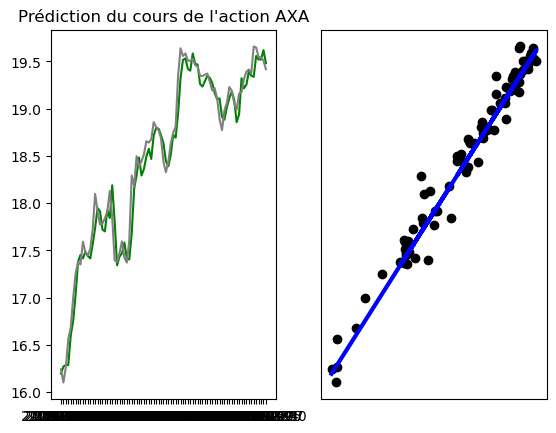

Mean squared error: 0.03
Coefficient of determination: 0.97


In [60]:
reg = LinearRegression()

X= df2[['Open']]
X = X[1:(len(X))]
p = int((2/3)*len(X))
X_train = X[:p]
X_test = X[p:]
reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
print(reg.coef_)

y_pred = reg.predict(X_test)
plt.subplot(121)
plt.plot(y_pred, color='green')
plt.plot(Y_test, color='gray')
plt.title("Prédiction du cours de l'action AXA")

plt.subplot(122)
plt.scatter(X_test, Y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(Y_test, y_pred))

On remarque ici que les courbes vertes et grises se chauffe assez régulièrement, ce qui montrent que la régression est possible.

Mais nous voulons voir si nous ne pouvons pas aller plus loin dans cette modélisation en rajoutant une nouvelle variable qui prendrait en compte les prix de fermeture de la veille. Nous allons donc créer cette nouvelle colonne dans notre tableau pour faire la modélisation.

In [58]:
dec=df_init["Close"].shift(1)
df_init= df_init.assign(Close_veille=dec)
df_init.head()

,Open,Close,Volume,Close_veille
Date,,,,
2019-01-02,13.595196,13.731001,8028529,NaN
2019-01-03,13.599574,13.617098,6583413,13.731001
2019-01-04,13.720779,14.044961,11675578,13.617098
2019-01-07,14.078547,13.982168,7530045,14.044961
2019-01-08,14.027438,14.034739,7314687,13.982168


[[0.85780781 0.12702797]]
Mean squared error: 0.03
Coefficient of determination: 0.97


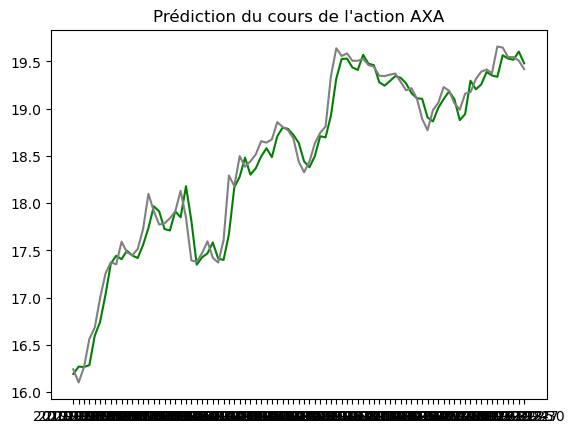

In [59]:
#On fait alors une régression en gardant pour variable explicative les prix de Open et de la fermeture de la veille
X = df_init[['Open', 'Close_veille']]
Y = df_init[['Close']]
X = X[1:len(X)]
Y = Y[1:len(Y)]



#On définit les tests, pour cela il nous faut une valeur ou arreter les données on la note p
p = int((2/3)*len(X))
X_train = X[:p]
Y_train = Y[:p]
X_test = X[p:]
Y_test = Y[p:]

#On passe désormais à la régression linéaire 
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
print(regr.coef_)

y_pred = regr.predict(X_test)
plt.plot(y_pred, color='green')
plt.plot(Y_test, color='gray')
plt.title("Prédiction du cours de l'action AXA")

from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(Y_test, y_pred))


In [181]:
#Calcul des log-rendements
Log_Rdt=np.log(df_init.Close/df_init.Close_veille)
df_init= df_init.assign(Log_Rdt=Log_Rdt)
df_init.head()

,Open,High,Low,Close,Volume,Dividends,Close_veille,Log_Rdt
Date,,,,,,,,
2019-01-02,13.595196,13.738302,13.455008,13.731001,8028529,0.0,NaN,NaN
2019-01-03,13.599576,13.836142,13.589354,13.617100,6583413,0.0,13.731001,-0.008330
2019-01-04,13.720778,14.087309,13.666748,14.044960,11675578,0.0,13.617100,0.030937
2019-01-07,14.078546,14.150099,13.900392,13.982167,7530045,0.0,14.044960,-0.004481
2019-01-08,14.027437,14.218734,13.988010,14.034739,7314687,0.0,13.982167,0.003753


In [182]:
#Rajout d'un indice temporel dans la base de données
df_init.reset_index(level=None, inplace=True)
df_init= df_init.assign(t=df_init.index)
df_init.head()

,Date,Open,High,Low,Close,Volume,Dividends,Close_veille,Log_Rdt,t
0,2019-01-02,13.595196,13.738302,13.455008,13.731001,8028529,0.0,NaN,NaN,0
1,2019-01-03,13.599576,13.836142,13.589354,13.617100,6583413,0.0,13.731001,-0.008330,1
2,2019-01-04,13.720778,14.087309,13.666748,14.044960,11675578,0.0,13.617100,0.030937,2
3,2019-01-07,14.078546,14.150099,13.900392,13.982167,7530045,0.0,14.044960,-0.004481,3
4,2019-01-08,14.027437,14.218734,13.988010,14.034739,7314687,0.0,13.982167,0.003753,4


In [8]:
#Création d'une base de données d'apprentissage et d'une base de données de test

In [183]:
df=df_init.dropna()
X_BS=pd.DataFrame(df, columns=['Open','Close_veille','t','Log_Rdt'])
y_BS=pd.Series(df.Close)
X_BS_train, X_BS_test, y_BS_train, y_BS_test = train_test_split(X_BS, y_BS, test_size=0.2, random_state=0)

In [184]:
#Calcul de la moyenne des log-rendements
mu=np.mean(X_BS_train.Log_Rdt)
mu

0.0012513736856738

In [185]:
#Estimation de la volatilité des log-rendements : par souci de simplification, nous prenons l'écart-type des log-rendements
sigma=np.std(X_BS_train.Log_Rdt)*np.sqrt(len(X_BS_train))
sigma

0.12558465487181

In [186]:
#Ecriture d'une fonction qui estime le cours de l'action AXA par la formule de Black & Scholes à horizon d jour(s)

def Estim_cours_action(d):
    
    start_Date = datetime.datetime(2019, 1, 1)
    end_Date = datetime.datetime(2019, 12, 31)

    GetAXAInfo = yahooFinance.Ticker("CS.PA")

    df_init=GetAXAInfo.history(start=start_Date,end=end_Date)
    
    #Transformation du cours de l'action de la veille en une variable
    dec=df_init["Close"].shift(1)
    df_init= df_init.assign(Close_veille=dec)
    
    #Calcul des log-rendements
    Log_Rdt=np.log(df_init.Close/df_init.Close_veille)
    df_init= df_init.assign(Log_Rdt=Log_Rdt)
    
    #Rajout d'un indice temporel dans la base de données
    df_init.reset_index(level=0, inplace=True)
    df_init= df_init.assign(t=df_init.index)
    
    #Création d'une base de données d'apprentissage et d'une base de données de test
    df=df_init.dropna()
    X_BS=pd.DataFrame(df, columns=['Open','Close_veille','t','Log_Rdt'])
    y_BS=pd.Series(df.Close)
    X_BS_train, X_BS_test, y_BS_train, y_BS_test = train_test_split(X_BS, y_BS, test_size=0.2, random_state=0)
    
    #Calcul de la moyenne des log-rendements
    mu=np.mean(X_BS_train.Log_Rdt)
    
    #Estimation de la volatilité des log-rendements : par souci de simplification, nous prenons l'écart-type des log-rendements
    sigma=np.std(X_BS_train.Log_Rdt)*np.sqrt(len(X_BS_train))
    
    np.random.seed(94)
    val_norm=np.random.normal(0, 1)

    Est_Close_BS=y_BS_train[min(y_BS_train.index)]*np.exp((mu-(sigma**2)/2)*(d) + sigma*val_norm*np.sqrt(d))
    return Est_Close_BS

In [187]:
#Ecriture d'une fonction qui estime le cours de l'action AXA pour plusieurs horizons temporels donnés

def Estim_cours_action_serie(y):
    indexes=y.index
    Est_Close_BS_serie=[None]*len(indexes)
    j=0
    for i in indexes:
        Est_Close_BS_serie[j]=Estim_cours_action(i)
        j+=1
    Est_Close_BS_serie=pd.Series(Est_Close_BS_serie)
    return Est_Close_BS_serie

In [188]:
Estimation=Estim_cours_action_serie(y_BS_test)
indexes_0=Estimation.index

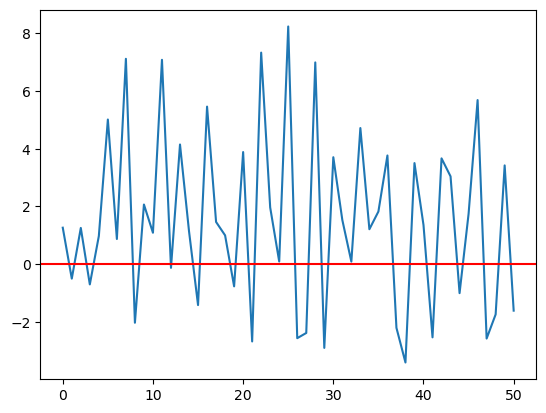

In [189]:
#Représentation graphique dee l'erreur de prédiction entre B&S et série réelle 

y_BS_test.index=indexes_0
Erreur=y_BS_test-Estimation
plt.plot(indexes_0, Erreur)
ay=plt.gca()
ay.axhline(y=0, color='red')

In [190]:
mse_BS=mean_squared_error(Estimation,y_BS_test)
mse_BS

11.569678518126901

In [ ]:
#Mise en oeuvre d'un modèle SVM : on cherche à prédire Close en fonction de Open et de Close_veille

In [191]:
#Base des variables dépendantes et normalisation des données
X_train_init=pd.DataFrame(X_BS_train, columns=['Open','Close_veille'])
X_test_init=pd.DataFrame(X_BS_test, columns=['Open','Close_veille'])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_init)
X_test = scaler.fit_transform(X_test_init)
column_names_train = X_train_init.columns
column_names_test = X_test_init.columns
X_train=pd.DataFrame(X_train, columns=column_names_train)
X_test=pd.DataFrame(X_test, columns=column_names_test)

In [192]:
#Vecteur de variable dépendante
y_train=y_BS_train
y_test=y_BS_test

In [193]:
#Mise en oeuvre du modèle
m1=svm.SVR()
m1.fit(X_train, y_train)

SVR()

In [23]:
#Evaluation du modèle SVM : calcul de : accuracy
accuracy = m1.score(X_test, y_test)
accuracy

0.953806196610228

In [24]:
#Evaluation du modèle SVM : calcul du MSE
y_pred=m1.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
mse

0.0681112844461976

In [ ]:
#En comparant les deux modèles (sur la base du critère MSE), il ressort que le modèle SVM (pour régression) est plus performant que la formule de B&S pour estimer le cours de l'action AXA à la clôture.
#Le modèle SVM a en effet produit un MSE beaucoup plus faible.

#On note également la bonne qualité de l'ajustement par modèle SVM, avec un accuracy à plus de 95%.

In [82]:
np.random.seed(111111000)
val_n=np.random.normal(0, 1)
val_n

0.29929814397553406